# Build a reinforcement learning environment for a virtual PIV setup

***

In [13]:
from pykitPIV.ml import PIVEnv
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import numpy as np
import onnxruntime
import torch
import sys, os

Prepare specs for pykitPIV parameters:

In [96]:
particle_spec = {'diameters': (1, 1),
                 'distances': (2, 2),
                 'densities': (0.2, 0.2),
                 'diameter_std': 1,
                 'seeding_mode': 'random'}

flowfield_spec = {'flowfield_size': (500, 1000),
                  'flowfield_type': 'random smooth',
                  'gaussian_filters': (10, 10),
                  'n_gaussian_filter_iter': 10,
                  'displacement': (2, 2)}

motion_spec = {'n_steps': 10,
               'time_separation': 5,
               'particle_loss': (0, 2),
               'particle_gain': (0, 2)}

image_spec = {'exposures': (0.5, 0.9),
              'maximum_intensity': 2**16-1,
              'laser_beam_thickness': 1,
              'laser_over_exposure': 1,
              'laser_beam_shape': 0.95,
              'alpha': 1/8,
              'clip_intensities': True,
              'normalize_intensities': False}

Use LIMA as an inference model:

In [97]:
class ONNXmodel:
    
    def __init__(self,
                 onnx_file_path):
        
        self.name = "ONNX"
        self.providers = ['CPUExecutionProvider']
        self.session = onnxruntime.InferenceSession(onnx_file_path, 
                                                    None,
                                                    providers=self.providers)

        self.input_name = self.session.get_inputs()[0].name  
        print('Input Name:', self.input_name)   
 
    def inference(self, x):
        
        output = self.session.run([], {self.input_name:x/np.max(x)})[0] 
      
        return output

    def empty(self):
        
         with torch.no_grad():
            torch.cuda.empty_cache()

In [98]:
model_file = '../Lima_L4_PAD_SR2_dyn.onnx'
print("model:", model_file, '  exist:', os.path.exists(model_file))

model: ../Lima_L4_PAD_SR2_dyn.onnx   exist: True


In [99]:
lima_inference_model = ONNXmodel(model_file)

Input Name: Input


Initialize the `Gymnasium` environment:

In [100]:
env = PIVEnv(interrogation_window_size=(100,100),
             interrogation_window_size_buffer=10,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             user_flowfield=None,
             inference_model=lima_inference_model,
             random_seed=100)

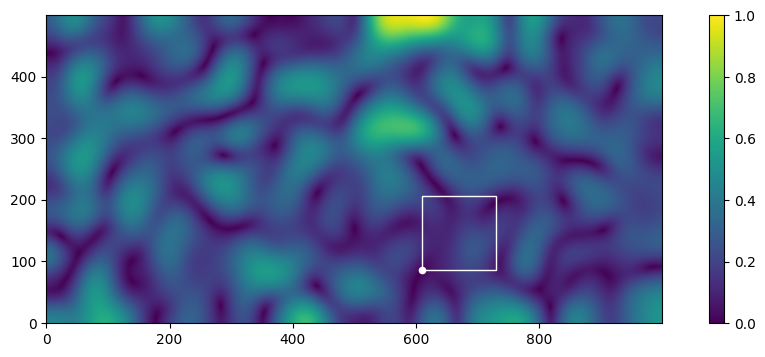

In [101]:
plt = env.render(camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 figsize=(12,4), 
                 filename='ml_PIVEnv_render.png')

In [102]:
camera_position, prediction_tensor, targets_tensor = env.reset()

(1, 2, 120, 120)
(100, 100)
10
Image 1:	21 particles lost
Particles added to the image.
Velocity field added to the image.
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.


In [103]:
prediction_tensor.shape

(1, 2, 100, 100)

In [104]:
targets_tensor.shape

(1, 2, 100, 100)

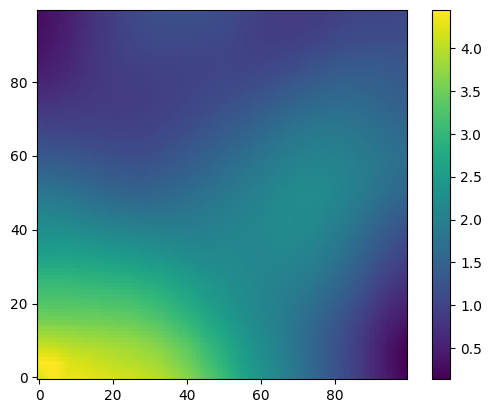

In [105]:
plt.imshow(np.sqrt(prediction_tensor[0,0,:,:]**2 + prediction_tensor[0,1,:,:]**2), origin='lower')
plt.colorbar();

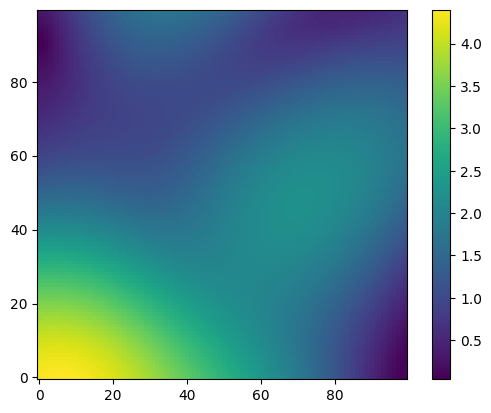

In [106]:
plt.imshow(np.sqrt(targets_tensor[0,0,:,:]**2 + targets_tensor[0,1,:,:]**2), origin='lower')
plt.colorbar();

In [88]:
image_obj = env.record_particles(camera_position)

(1, 2, 120, 120)
(100, 100)
10
Image 1:	21 particles lost
Particles added to the image.
Velocity field added to the image.
Particle movement added to the image.
Reflected light added to images I1.
Reflected light added to images I2.


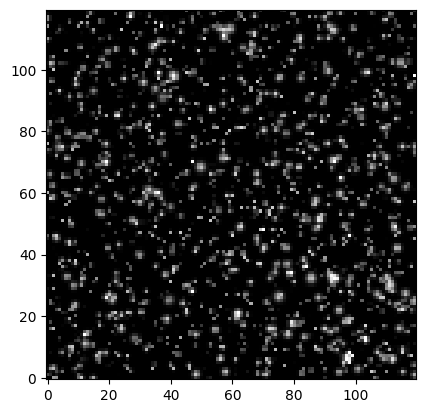

In [89]:
plt.imshow(image_obj.images_I1[0,0,:,:], cmap='Greys_r', origin='lower')

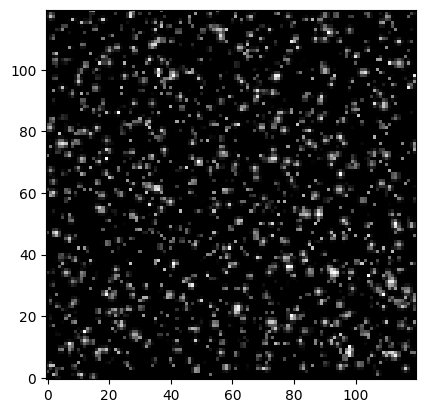

In [90]:
plt.imshow(image_obj.images_I2[0,0,:,:], cmap='Greys_r', origin='lower')

<module 'matplotlib.pyplot' from '/Users/kamilazdybal/anaconda3/envs/lima-pykitPIV/lib/python3.10/site-packages/matplotlib/pyplot.py'>

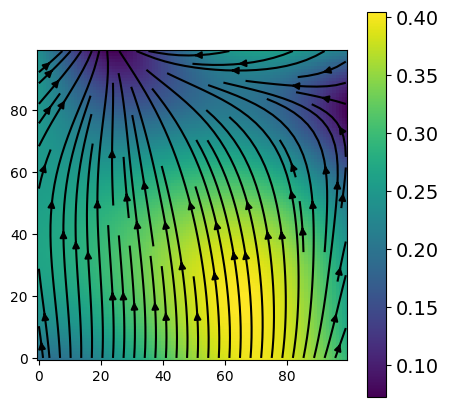

In [91]:
image_obj.plot_field_magnitude(0, 
                               add_streamplot=True,
                               streamplot_density=1,
                               streamplot_color='k',)

MovieWriter ffmpeg unavailable; using Pillow instead.


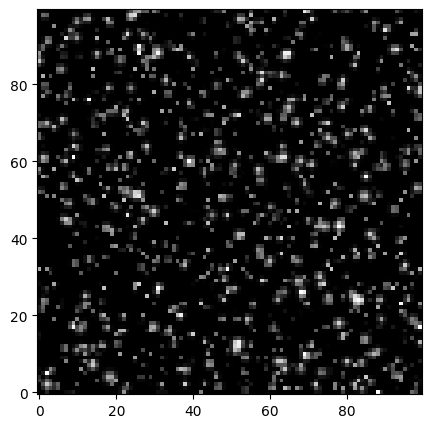

In [92]:
image_obj.animate_image_pair(0, filename='image.gif')

***